## VGG16

In [ ]:
import os
import numpy as np
import torch


import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch.optim as optim

%matplotlib inline

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

In [ ]:
# define training and test data directories
train_dir = './data/Train'
test_dir = './data/Test'

# classes are folders in each directory with these names
classes = ['Biryani', 'Bun Kabab', 'Chaat', 'Chicken Tikka', 'Daal', 
           'Fruit Chart', 'Gajar ka halwa', 'Gulab Jamun', 'Jalebi','Karhai',
            'Keema', 'Kheer', 'Kofta', 'Kulfa', 'Nihari', 
            'Palak', 'Roti', 'Samosas', 'Seekh kebab', 'Shahi Tukray']

# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

In [ ]:
# define dataloader parameters
batch_size = 128
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(40, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

In [ ]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features)  

In [ ]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

In [ ]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 1

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = vgg16(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
        if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 413 test images: %d %%' % (
    100 * correct / total))

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(40, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

# BaseLine Model #1: Classification

In [1]:
import numpy as np
import keras

from keras.layers import Dense,GlobalAveragePooling2D
from keras.layers.core import Dense

from keras.applications import MobileNet
from keras.applications import ResNet50
from keras.applications import ResNet101
from keras.applications import InceptionV3
from keras.applications import VGG16


from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam,SGD

from keras.models import Model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import os
%matplotlib inline

Using TensorFlow backend.


### Load Data

In [2]:
train_path = './data/Train/'
val_path = './data/CrossVelidation/'
test_path = './data/Test/'

### Model Configration

In [3]:
image_size = (128,128)
batch_size = 128
learing_rate = 0.001
no_epochs=100
optimizer1 = keras.optimizers.Adam(lr=learing_rate, amsgrad=True)
#optimizer1 = keras.optimizers.SGD(lr=learing_rate, amsgrad=True)

In [4]:
train_datagen=ImageDataGenerator() 
val_datagen=ImageDataGenerator() 
test_datagen=ImageDataGenerator()

train_generator=train_datagen.flow_from_directory( train_path,
                                                   target_size=image_size,
                                                   color_mode='rgb',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)


valid_batches=train_datagen.flow_from_directory( val_path,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)


test_batches=train_datagen.flow_from_directory( test_path,
                                                target_size=image_size,
                                                color_mode='rgb',
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=True)

trainStep_size_train=train_generator.n//train_generator.batch_size
valStep_size_train=valid_batches.n//valid_batches.batch_size
testStep_size_train=test_batches.n//test_batches.batch_size

Found 4891 images belonging to 20 classes.
Found 1533 images belonging to 20 classes.
Found 1633 images belonging to 20 classes.


In [5]:
pclasses = ['P-Biryani', 'P-Bun Kabab', 'P-Chaat', 'P-Chicken Tikka', 'P-Daal', 
           'P-Fruit Chart', 'P-Gajar ka halwa', 'P-Gulab Jamun', 'P-Jalebi','Karhai',
            'P-Keema', 'P-Kheer', 'P-Kofta', 'P-Kulfa', 'P-Nihari', 
            'P-Palak', 'P-Roti', 'P-Samosas', 'P-Seekh kebab', 'P-Shahi Tukray']
classes = ['Biryani', 'Bun Kabab', 'Chaat', 'Chicken Tikka', 'Daal', 
           'Fruit Chart', 'Gajar ka halwa', 'Gulab Jamun', 'Jalebi','Karhai',
            'Keema', 'Kheer', 'Kofta', 'Kulfa', 'Nihari', 
            'Palak', 'Roti', 'Samosas', 'Seekh kebab', 'Shahi Tukray']

## MobileNet

In [6]:
base_model=MobileNet(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)
preds=Dense(20,activation='softmax')(x) 
model=Model(inputs=base_model.input,outputs=preds)
print(model.summary())

C:\Users\Fyp-FoodParts\Anaconda3\envs\cuda\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [7]:
for layer in model.layers:
      layer.trainable = True

# for l in model.layers:
#     print(l.name, l.trainable)

In [8]:
model.compile(optimizer=optimizer1,loss='categorical_crossentropy',metrics=['accuracy', 'top_k_categorical_accuracy'])

history=model.fit_generator(generator=train_generator,steps_per_epoch=trainStep_size_train,
                             validation_data=valid_batches,validation_steps=valStep_size_train,
                             epochs=no_epochs,verbose=2)

Epoch 1/100


C:\Users\Fyp-FoodParts\Anaconda3\envs\cuda\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 - 27s - loss: 1.7501 - accuracy: 0.5257 - top_k_categorical_accuracy: 0.8043 - val_loss: 5.0369 - val_accuracy: 0.3409 - val_top_k_categorical_accuracy: 0.6506
Epoch 2/100
 - 19s - loss: 0.6233 - accuracy: 0.8146 - top_k_categorical_accuracy: 0.9721 - val_loss: 4.9878 - val_accuracy: 0.2940 - val_top_k_categorical_accuracy: 0.6961
Epoch 3/100
 - 19s - loss: 0.3465 - accuracy: 0.8967 - top_k_categorical_accuracy: 0.9916 - val_loss: 1.7756 - val_accuracy: 0.5317 - val_top_k_categorical_accuracy: 0.8477
Epoch 4/100
 - 19s - loss: 0.2770 - accuracy: 0.9227 - top_k_categorical_accuracy: 0.9954 - val_loss: 1.6469 - val_accuracy: 0.6669 - val_top_k_categorical_accuracy: 0.9231
Epoch 5/100
 - 18s - loss: 0.2098 - accuracy: 0.9410 - top_k_categorical_accuracy: 0.9966 - val_loss: 3.4354 - val_accuracy: 0.4235 - val_top_k_categorical_accuracy: 0.8050
Epoch 6/100
 - 18s - loss: 0.1635 - accuracy: 0.9521 - top_k_categorical_accuracy: 0.9985 - val_loss: 2.1015 - val_accuracy: 0.5687 - val_top_k_cat

Epoch 49/100
 - 16s - loss: 0.0360 - accuracy: 0.9943 - top_k_categorical_accuracy: 0.9994 - val_loss: 1.1162 - val_accuracy: 0.7564 - val_top_k_categorical_accuracy: 0.9347
Epoch 50/100
 - 19s - loss: 0.1451 - accuracy: 0.9717 - top_k_categorical_accuracy: 0.9956 - val_loss: 3.6022 - val_accuracy: 0.4754 - val_top_k_categorical_accuracy: 0.7046
Epoch 51/100
 - 19s - loss: 0.0973 - accuracy: 0.9764 - top_k_categorical_accuracy: 0.9981 - val_loss: 1.3867 - val_accuracy: 0.7060 - val_top_k_categorical_accuracy: 0.8719
Epoch 52/100
 - 18s - loss: 0.0583 - accuracy: 0.9856 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.5244 - val_accuracy: 0.6292 - val_top_k_categorical_accuracy: 0.8491
Epoch 53/100
 - 18s - loss: 0.0498 - accuracy: 0.9882 - top_k_categorical_accuracy: 0.9992 - val_loss: 1.4242 - val_accuracy: 0.7438 - val_top_k_categorical_accuracy: 0.9096
Epoch 54/100
 - 16s - loss: 0.0197 - accuracy: 0.9936 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.2295 - val_accuracy: 0.79

Epoch 97/100
 - 16s - loss: 0.0370 - accuracy: 0.9903 - top_k_categorical_accuracy: 0.9992 - val_loss: 1.5806 - val_accuracy: 0.7805 - val_top_k_categorical_accuracy: 0.9332
Epoch 98/100
 - 18s - loss: 0.0199 - accuracy: 0.9950 - top_k_categorical_accuracy: 0.9998 - val_loss: 1.4426 - val_accuracy: 0.8071 - val_top_k_categorical_accuracy: 0.9445
Epoch 99/100
 - 17s - loss: 0.0188 - accuracy: 0.9943 - top_k_categorical_accuracy: 0.9998 - val_loss: 1.6441 - val_accuracy: 0.7708 - val_top_k_categorical_accuracy: 0.9310
Epoch 100/100
 - 17s - loss: 0.0244 - accuracy: 0.9956 - top_k_categorical_accuracy: 0.9994 - val_loss: 1.0553 - val_accuracy: 0.8043 - val_top_k_categorical_accuracy: 0.9473


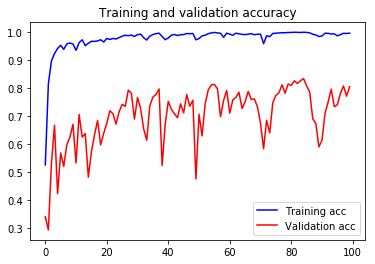

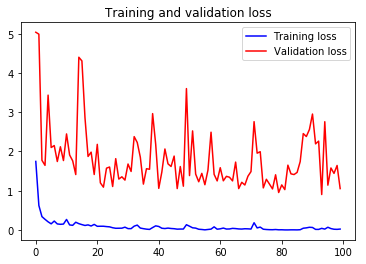

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [10]:
scores = model.evaluate_generator(test_batches,len(test_batches)) #1514 testing images
print("Accuracy = ", scores[1])

Accuracy =  0.8009797930717468


## ResNet101

In [11]:
base_model=MobileNet(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)
preds=Dense(20,activation='softmax')(x) 
model=Model(inputs=base_model.input,outputs=preds)
print(model.summary())

C:\Users\Fyp-FoodParts\Anaconda3\envs\cuda\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [12]:
for layer in model.layers:
      layer.trainable = True

# for l in model.layers:
#     print(l.name, l.trainable)

In [13]:
model.compile(optimizer=optimizer1,loss='categorical_crossentropy',metrics=['accuracy', 'top_k_categorical_accuracy'])

history=model.fit_generator(generator=train_generator,steps_per_epoch=trainStep_size_train,
                             validation_data=valid_batches,validation_steps=valStep_size_train,
                             epochs=no_epochs,verbose=2)

Epoch 1/100


C:\Users\Fyp-FoodParts\Anaconda3\envs\cuda\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 - 21s - loss: 3.3158 - accuracy: 0.1396 - top_k_categorical_accuracy: 0.4132 - val_loss: 10.0521 - val_accuracy: 0.0547 - val_top_k_categorical_accuracy: 0.2273
Epoch 2/100
 - 20s - loss: 2.3380 - accuracy: 0.2423 - top_k_categorical_accuracy: 0.6550 - val_loss: 10.1668 - val_accuracy: 0.0498 - val_top_k_categorical_accuracy: 0.2157
Epoch 3/100
 - 20s - loss: 1.9325 - accuracy: 0.3569 - top_k_categorical_accuracy: 0.7995 - val_loss: 5.7414 - val_accuracy: 0.0598 - val_top_k_categorical_accuracy: 0.3053
Epoch 4/100
 - 18s - loss: 1.6248 - accuracy: 0.4480 - top_k_categorical_accuracy: 0.8654 - val_loss: 4.5412 - val_accuracy: 0.1324 - val_top_k_categorical_accuracy: 0.4577
Epoch 5/100
 - 19s - loss: 1.3905 - accuracy: 0.5234 - top_k_categorical_accuracy: 0.9148 - val_loss: 4.9196 - val_accuracy: 0.1829 - val_top_k_categorical_accuracy: 0.5573
Epoch 6/100
 - 18s - loss: 1.1382 - accuracy: 0.6020 - top_k_categorical_accuracy: 0.9476 - val_loss: 3.4541 - val_accuracy: 0.2527 - val_top_k_c

Epoch 49/100
 - 15s - loss: 0.0203 - accuracy: 0.9951 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9973 - val_accuracy: 0.6982 - val_top_k_categorical_accuracy: 0.8913
Epoch 50/100
 - 19s - loss: 0.0395 - accuracy: 0.9922 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.7995 - val_accuracy: 0.6612 - val_top_k_categorical_accuracy: 0.8762
Epoch 51/100
 - 19s - loss: 0.0625 - accuracy: 0.9807 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.3262 - val_accuracy: 0.5174 - val_top_k_categorical_accuracy: 0.8384
Epoch 52/100
 - 19s - loss: 0.0312 - accuracy: 0.9907 - top_k_categorical_accuracy: 0.9996 - val_loss: 2.3017 - val_accuracy: 0.6605 - val_top_k_categorical_accuracy: 0.8847
Epoch 53/100
 - 17s - loss: 0.1173 - accuracy: 0.9710 - top_k_categorical_accuracy: 0.9994 - val_loss: 2.6622 - val_accuracy: 0.5929 - val_top_k_categorical_accuracy: 0.8776
Epoch 54/100
 - 17s - loss: 0.0488 - accuracy: 0.9864 - top_k_categorical_accuracy: 0.9994 - val_loss: 1.8762 - val_accuracy: 0.68

Epoch 97/100
 - 15s - loss: 0.0063 - accuracy: 0.9987 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.7194 - val_accuracy: 0.7180 - val_top_k_categorical_accuracy: 0.9062
Epoch 98/100
 - 18s - loss: 0.0277 - accuracy: 0.9943 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.1954 - val_accuracy: 0.7117 - val_top_k_categorical_accuracy: 0.9203
Epoch 99/100
 - 18s - loss: 0.0132 - accuracy: 0.9962 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.4181 - val_accuracy: 0.7452 - val_top_k_categorical_accuracy: 0.9011
Epoch 100/100
 - 16s - loss: 0.0130 - accuracy: 0.9974 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.0344 - val_accuracy: 0.7224 - val_top_k_categorical_accuracy: 0.9060


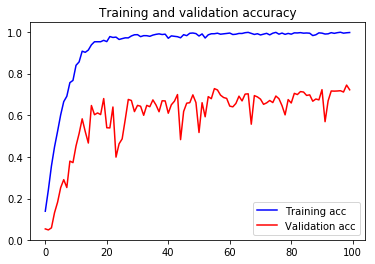

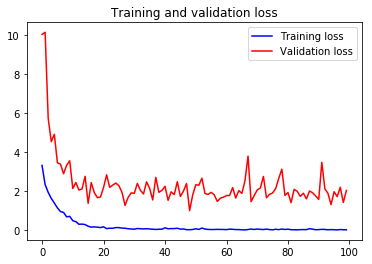

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [15]:
scores = model.evaluate_generator(test_batches,len(test_batches)) #1514 testing images
print("Accuracy = ", scores[1])

Accuracy =  0.7452541589736938


## ResNet50

In [16]:
base_model=ResNet50(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)
preds=Dense(20,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)
print(model.summary())

C:\Users\Fyp-FoodParts\Anaconda3\envs\cuda\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [17]:
for layer in model.layers:
      layer.trainable = True

# for l in model.layers:
#     print(l.name, l.trainable)

In [18]:
model.compile(optimizer=optimizer1,loss='categorical_crossentropy',metrics=['accuracy', 'top_k_categorical_accuracy'])

history=model.fit_generator(generator=train_generator,steps_per_epoch=trainStep_size_train,
                             validation_data=valid_batches,validation_steps=valStep_size_train,
                             epochs=no_epochs,verbose=2)

Epoch 1/100


C:\Users\Fyp-FoodParts\Anaconda3\envs\cuda\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 - 41s - loss: 3.3943 - accuracy: 0.1201 - top_k_categorical_accuracy: 0.3903 - val_loss: 375342240.0000 - val_accuracy: 0.0419 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/100
 - 25s - loss: 2.5898 - accuracy: 0.1904 - top_k_categorical_accuracy: 0.5734 - val_loss: 1431.9401 - val_accuracy: 0.0719 - val_top_k_categorical_accuracy: 0.8968
Epoch 3/100
 - 24s - loss: 2.4285 - accuracy: 0.2244 - top_k_categorical_accuracy: 0.6349 - val_loss: 9.3536 - val_accuracy: 0.1260 - val_top_k_categorical_accuracy: 0.4655
Epoch 4/100
 - 24s - loss: 2.3058 - accuracy: 0.2603 - top_k_categorical_accuracy: 0.6897 - val_loss: 2.6797 - val_accuracy: 0.2206 - val_top_k_categorical_accuracy: 0.5922
Epoch 5/100
 - 24s - loss: 2.1790 - accuracy: 0.2975 - top_k_categorical_accuracy: 0.7193 - val_loss: 6.5464 - val_accuracy: 0.1246 - val_top_k_categorical_accuracy: 0.4584
Epoch 6/100
 - 24s - loss: 2.0802 - accuracy: 0.3235 - top_k_categorical_accuracy: 0.7554 - val_loss: 4.2083 - val_accuracy: 0.2121 - va

Epoch 49/100
 - 22s - loss: 0.0998 - accuracy: 0.9731 - top_k_categorical_accuracy: 0.9992 - val_loss: 2.8118 - val_accuracy: 0.4936 - val_top_k_categorical_accuracy: 0.8068
Epoch 50/100
 - 26s - loss: 0.0511 - accuracy: 0.9858 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.6931 - val_accuracy: 0.5260 - val_top_k_categorical_accuracy: 0.8320
Epoch 51/100
 - 24s - loss: 0.0890 - accuracy: 0.9732 - top_k_categorical_accuracy: 0.9994 - val_loss: 3.5580 - val_accuracy: 0.4954 - val_top_k_categorical_accuracy: 0.8228
Epoch 52/100
 - 24s - loss: 0.0599 - accuracy: 0.9827 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.4903 - val_accuracy: 0.5687 - val_top_k_categorical_accuracy: 0.8520
Epoch 53/100
 - 24s - loss: 0.0788 - accuracy: 0.9813 - top_k_categorical_accuracy: 0.9996 - val_loss: 4.3431 - val_accuracy: 0.3886 - val_top_k_categorical_accuracy: 0.7644
Epoch 54/100
 - 23s - loss: 0.0687 - accuracy: 0.9788 - top_k_categorical_accuracy: 0.9998 - val_loss: 3.9923 - val_accuracy: 0.45

Epoch 97/100
 - 22s - loss: 0.0733 - accuracy: 0.9792 - top_k_categorical_accuracy: 0.9991 - val_loss: 2.3645 - val_accuracy: 0.5469 - val_top_k_categorical_accuracy: 0.8445
Epoch 98/100
 - 25s - loss: 0.0257 - accuracy: 0.9903 - top_k_categorical_accuracy: 1.0000 - val_loss: 3.3785 - val_accuracy: 0.5751 - val_top_k_categorical_accuracy: 0.8612
Epoch 99/100
 - 25s - loss: 0.0138 - accuracy: 0.9951 - top_k_categorical_accuracy: 1.0000 - val_loss: 3.3725 - val_accuracy: 0.5893 - val_top_k_categorical_accuracy: 0.8498
Epoch 100/100
 - 24s - loss: 0.0216 - accuracy: 0.9938 - top_k_categorical_accuracy: 0.9998 - val_loss: 3.3482 - val_accuracy: 0.5167 - val_top_k_categorical_accuracy: 0.8313


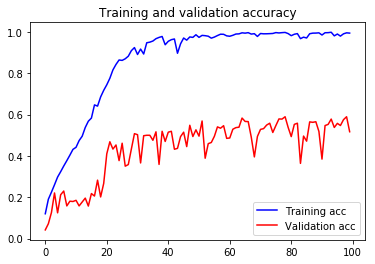

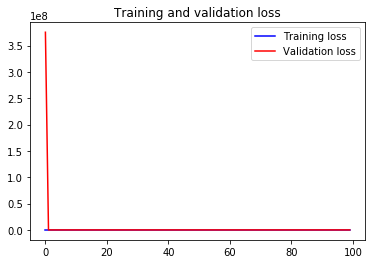

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [20]:
scores = model.evaluate_generator(test_batches,len(test_batches)) 
print("Accuracy = ", scores[1])

Accuracy =  0.5260257124900818


## InceptionV3 

In [21]:
base_model=InceptionV3(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)
preds=Dense(20,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=preds)
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [22]:
for layer in model.layers:
      layer.trainable = True

# for l in model.layers:
#     print(l.name, l.trainable)

In [23]:
model.compile(optimizer=optimizer1,loss='categorical_crossentropy',metrics=['accuracy', 'top_k_categorical_accuracy'])

history=model.fit_generator(generator=train_generator,steps_per_epoch=trainStep_size_train,
                             validation_data=valid_batches,validation_steps=valStep_size_train,
                             epochs=no_epochs,verbose=2)

Epoch 1/100


C:\Users\Fyp-FoodParts\Anaconda3\envs\cuda\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 - 102s - loss: 3.1950 - accuracy: 0.0726 - top_k_categorical_accuracy: 0.3147 - val_loss: 39961001984.0000 - val_accuracy: 0.0277 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/100
 - 32s - loss: 2.9559 - accuracy: 0.0666 - top_k_categorical_accuracy: 0.3303 - val_loss: 105992.8828 - val_accuracy: 0.0285 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/100
 - 20s - loss: 2.9535 - accuracy: 0.0768 - top_k_categorical_accuracy: 0.3359 - val_loss: 186.3209 - val_accuracy: 0.0292 - val_top_k_categorical_accuracy: 0.7673
Epoch 4/100
 - 20s - loss: 2.9442 - accuracy: 0.0762 - top_k_categorical_accuracy: 0.3387 - val_loss: 4.8803 - val_accuracy: 0.0434 - val_top_k_categorical_accuracy: 0.2840
Epoch 5/100
 - 20s - loss: 2.8937 - accuracy: 0.0950 - top_k_categorical_accuracy: 0.3701 - val_loss: 2.9692 - val_accuracy: 0.0754 - val_top_k_categorical_accuracy: 0.3388
Epoch 6/100
 - 20s - loss: 2.8691 - accuracy: 0.1002 - top_k_categorical_accuracy: 0.3923 - val_loss: 3.2376 - val_accuracy: 0.05

Epoch 49/100
 - 17s - loss: 0.6384 - accuracy: 0.8045 - top_k_categorical_accuracy: 0.9824 - val_loss: 2.7065 - val_accuracy: 0.4702 - val_top_k_categorical_accuracy: 0.7891
Epoch 50/100
 - 21s - loss: 0.4676 - accuracy: 0.8463 - top_k_categorical_accuracy: 0.9912 - val_loss: 3.4303 - val_accuracy: 0.4235 - val_top_k_categorical_accuracy: 0.7758
Epoch 51/100
 - 21s - loss: 0.3029 - accuracy: 0.9020 - top_k_categorical_accuracy: 0.9958 - val_loss: 2.5646 - val_accuracy: 0.5210 - val_top_k_categorical_accuracy: 0.8470
Epoch 52/100
 - 21s - loss: 0.2752 - accuracy: 0.9095 - top_k_categorical_accuracy: 0.9977 - val_loss: 1.9282 - val_accuracy: 0.5466 - val_top_k_categorical_accuracy: 0.8534
Epoch 53/100
 - 20s - loss: 0.2041 - accuracy: 0.9363 - top_k_categorical_accuracy: 0.9988 - val_loss: 3.3346 - val_accuracy: 0.4883 - val_top_k_categorical_accuracy: 0.8085
Epoch 54/100
 - 18s - loss: 0.2402 - accuracy: 0.9266 - top_k_categorical_accuracy: 0.9974 - val_loss: 2.1273 - val_accuracy: 0.55

Epoch 97/100
 - 17s - loss: 0.0626 - accuracy: 0.9849 - top_k_categorical_accuracy: 0.9996 - val_loss: 3.4942 - val_accuracy: 0.5462 - val_top_k_categorical_accuracy: 0.8303
Epoch 98/100
 - 20s - loss: 0.0966 - accuracy: 0.9749 - top_k_categorical_accuracy: 0.9991 - val_loss: 3.1222 - val_accuracy: 0.5637 - val_top_k_categorical_accuracy: 0.8683
Epoch 99/100
 - 19s - loss: 0.0616 - accuracy: 0.9832 - top_k_categorical_accuracy: 0.9998 - val_loss: 2.8204 - val_accuracy: 0.6071 - val_top_k_categorical_accuracy: 0.8847
Epoch 100/100
 - 18s - loss: 0.0368 - accuracy: 0.9889 - top_k_categorical_accuracy: 1.0000 - val_loss: 2.5122 - val_accuracy: 0.6299 - val_top_k_categorical_accuracy: 0.8911


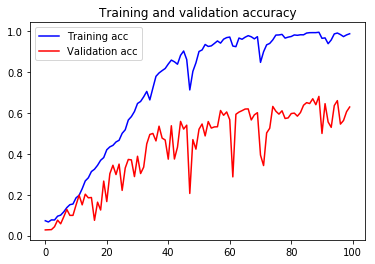

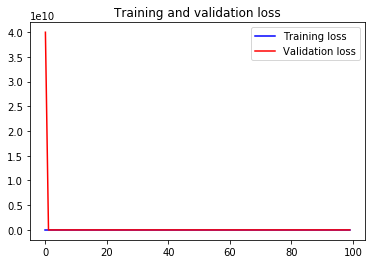

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [25]:
scores = model.evaluate_generator(test_batches,len(test_batches)) 
print("Accuracy = ", scores[1])

Accuracy =  0.6521739363670349


['accuracy']